# 生成式对抗网络

[![下载Notebook](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/cv/mindspore_dcgan.ipynb)&emsp;
[![下载样例代码](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/cv/mindspore_dcgan.py)&emsp;
[![查看源文件](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/application/source_zh_cn/cv/dcgan.ipynb)

## GAN基础原理

生成式对抗网络（Generative Adversarial Networks，GAN）是一种深度学习模型，是近年来复杂分布上无监督学习最具前景的方法之一。

最初，GAN由Ian Goodfellow于2014年发明，并在论文[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述，GAN由两个不同的模型组成：**生成器**和**判别器**：

- 生成器的任务是生成看起来像训练图像的“假”图像；
- 判别器需要判断从生成器输出的图像是真实的训练图像还是虚假的图像。

在训练过程中，生成器会不断尝试通过生成更好的假图像来骗过判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的假图像和训练数据图像的分布完全一致时，判别器拥有50%的真假判断置信度。

下面，我们首先定义一些在整个过程中需要用到的符号：

- $x$：代表图像数据。
- $D(x)$：判别器网络，给出图像判定为真实图像的概率。

由于我们在判别过程中需要处理图像，因此要为$D(x)$提供CHW格式且大小为3x64x64的图像。当$x$来自训练数据时，$D(x)$数值应该趋近于1，而当$x$来自生成器时，$D(x)$数值应该趋近于0。因此$D(x)$也可以被认为是传统的二分类器。

接下来我们来定义生成器的表示方法：

- $z$：标准正态分布中提取出的隐向量。
- $G(z)$：表示将隐向量$z$映射到数据空间的生成器函数。

函数$G(z)$的目标是将一个随机高斯噪声$z$通过一个生成网络生成一个和真实数据分布$pdata(x)$差不多的数据分布，其中$θ$是网络参数，我们希望找到$θ$使得$pG(x;θ)$和$pdata(x)$尽可能的接近。

- $D(G(z))$是生成器$G$生成的假图像被判定为真实图像的概率。

如[Goodfellow 的论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，`D`和`G`在进行一场博弈，`D`想要最大程度的正确分类真图像与假图像，也就是参数$log D(x)$；而`G`试图欺骗`D`来最小化假图像被识别到的概率，也就是参数$log(1−D(G(z)))$。GAN的损失函数为：

$$\min_{G}\max_{D}V(D,G)=E_{x\sim_Pdata(x)}[log(D(x))]+E_{z\sim_Pz(z)}[log(1-D(G(z)))]$$

从理论上讲，此博弈游戏的平衡点是$pG(x;θ) = pdata(x)$，此时判别器会随机猜测输入是真图像还是假图像。然而，GAN的收敛可行性仍在研究当中，在实际场景中模型并不会被训练到这一步。

### DCGAN

DCGAN（深度卷积对抗生成网络）是GAN的直接扩展。不同之处在于，DCGAN会分别在判别器和生成器中使用卷积和卷积转置层。

它最早由Radford等人在论文[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)中进行描述。判别器由分层的卷积层、BatchNorm层和LeakyReLU激活层组成。输入是3x64x64的图像，输出是该图像为真图像的概率。生成器则是由转置卷积层、BatchNorm层和ReLU激活层组成。输入是标准正态分布中提取出的隐向量$z$，输出是3x64x64的RGB图像。

本教程将使用70,171张动漫头像数据集来训练一个生成对抗网络，接着使用该网络生成动漫头像图片。

## DCGAN实践

在下面的教程中，我们将通过示例代码说明如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。在本教程中，我们使用的[动漫头像数据集](https://gitee.com/zhaoyu2012/docs/raw/TestDCGAN/faces.zip)共有70,171张动漫头像图片，图片大小均为96\*96。首先我们将数据集下载到指定目录下并解压。目录结构如下：

```text
./datasets/faces
├── 0.jpg
├── 1.jpg
├── 2.jpg
├── 3.jpg
├── 4.jpg
    ...
├── 70169.jpg
└── 70170.jpg
```

### 数据处理

首先为执行过程定义一些输入：

- `data_root`：数据集文件夹根目录；
- `workers`：加载数据的线程数；
- `batch_size`：训练中使用的批量大小，DCGAN论文使用的批量大小为128；
- `image_size`：训练图像的大小，此实现默认为`64x64`，如果需要其他尺寸，则必须同时更改`D`和`G`的结构；
- `nc`：输入图像中的彩色通道数，因为此次是彩色图像所以设为3；
- `nz`：隐向量的长度；
- `ngf`：设置通过生成器的特征图的深度；
- `ndf`：设置通过判别器传播的特征图的深度；
- `num_epochs`：要运行的训练周期数，训练更长的时间可能会导致更好的结果，但也会花费更长的时间；
- `lr`：训练的学习率；
- `beta1`：Adam优化器的`beta1`超参数。如DCGAN论文所述，该数字应为0.5；

In [1]:
from mindspore import context

# 制定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

data_root = "./datasets"  # 数据集根目录
workers = 4  # 载入数据线程数
batch_size = 128  # 批量大小
image_size = 64  # 训练图像空间大小，所有图像都将调整为该大小
nc = 3  # 图像彩色通道数，对于彩色图像为3
nz = 100  # 隐向量的长度
ngf = 64  # 特征图在生成器中的大小
ndf = 64  # 特征图在判别器中的大小
num_epochs = 10  # 训练周期数
lr = 0.0002  # 学习率
beta1 = 0.5  # Beta1 超参数

定义`create_dataset_imagenet`函数对数据进行处理和增强操作。

In [2]:
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

from mindspore import nn, ops, Tensor
from mindspore import dtype as mstype

def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True,
                                     decode=True)

    # 数据增强操作
    transform_img = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))
    ]

    # 数据映射操作
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns=["image", "latent_code"], column_order=["image", "latent_code"])

    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set

# 获取处理后的数据集
data = create_dataset_imagenet(data_root, num_parallel_workers=workers)

# 获取数据集大小
size = data.get_dataset_size()

通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

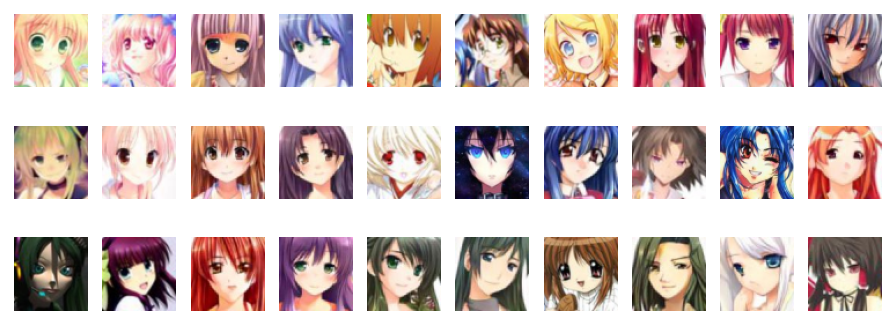

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

data_iter = next(data.create_dict_iterator(output_numpy=True))

# 可视化部分训练数据
plt.figure(figsize=(8, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

### 创建网络

当处理完数据后，就可以来进行网络的搭建了。网络搭建将以权重初始化策略为起点，逐一详细讨论生成器、判别器和损失函数。

#### 权重初始化

教程遵循DCGAN论文中的内容，所有模型权重均应从`mean`为0，`sigma`为0.02的正态分布中随机初始化。

In [4]:
from mindspore.common.initializer import Initializer

def _assignment(arr, num):
    if arr.shape == ():
        arr = arr.reshape(1)
        arr[:] = num
        arr = arr.reshape(())
    else:
        if isinstance(num, np.ndarray):
            arr[:] = num[:]
        else:
            arr[:] = num
    return arr


class Normal(Initializer):
    """将模型权重从均值为0，标准差为0.02的正态分布中随机初始化"""

    def __init__(self, mean=0.0, sigma=0.02):
        super(Normal, self).__init__()
        self.sigma = sigma
        self.mean = mean

    def _initialize(self, arr):
        np.random.seed(999)
        arr_normal = np.random.normal(self.mean, self.sigma, arr.shape)
        _assignment(arr, arr_normal)

#### 生成器

生成器`G`的功能是将隐向量`z`映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的 RGB 图像。在实践场景中，该功能是通过一系列`Conv2dTranspose`转置卷积层来完成的，每个层都与`BatchNorm2d`层和`ReLu`激活层配对，输出数据会经过`tanh`函数，使其返回`[-1,1]`的数据范围内。

DCGAN论文生成图像如下所示：

![dcgangenerator](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/application/source_zh_cn/cv/images/dcgan.png)

> 图片来源 https://arxiv.org/pdf/1511.06434.pdf

我们通过输入部分中设置的`nz`、`ngf`和`nc`来影响代码中的生成器结构。`nz`是隐向量`z`的长度，`ngf`与通过生成器传播的特征图的大小有关，`nc`是输出图像中的通道数。

以下是生成器的代码实现：

In [5]:
def conv_t(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义转置卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

def bn(num_features):
    """定义BatchNorm2d层"""
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(conv_t(nz, ngf * 8, 4, 1, 0))
        self.generator.append(bn(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(bn(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(bn(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(bn(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)

# 实例化生成器
netG = Generator()

#### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真实图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

DCGAN论文提到，使用卷积而不是通过池化来进行下采样是一个好方法，因为它可以让网络学习自己的池化特征。

判别器的代码实现如下：

In [6]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(bn(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(bn(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(bn(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

# 实例化判别器
netD = Discriminator()

### 连接网络和损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

- 连接生成器和损失函数，代码如下：

In [7]:
class WithLossCellG(nn.Cell):
    """连接生成器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        ones = ops.Ones()
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label = ones(out.shape, mstype.float32)
        loss = self.loss_fn(out, label)
        return loss

- 连接判别器和损失函数，代码如下：

In [8]:
class WithLossCellD(nn.Cell):
    """连接判别器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        ones = ops.Ones()
        zeros = ops.Zeros()

        out1 = self.netD(real_data)
        label1 = ones(out1.shape, mstype.float32)
        loss1 = self.loss_fn(out1, label1)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out2 = self.netD(fake_data)
        label2 = zeros(out2.shape, mstype.float32)
        loss2 = self.loss_fn(out2, label2)
        return loss1 + loss2

### 损失函数和优化器

当定义了`D`和`G`后，接下来将使用MindSpore中定义的二进制交叉熵损失函数[BCELoss](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/nn/mindspore.nn.BCELoss.html)
，为`D`和`G`加上损失函数和优化器。

这里设置了两个单独的优化器，一个用于`D`，另一个用于`G`。这两个都是`lr = 0.0002`和`beta1 = 0.5`的Adam优化器。为此将真实标签定义为1，将虚假标签定义为0，该标签在分别计算`D`和`G`的损失时使用。

为了跟踪生成器的学习进度，将生成一批固定的遵循高斯分布的隐向量 `fixed_noise`。在训练的过程中，定期将`fixed_noise`输入到`G`中，可以看到隐向量生成的图像。

In [9]:
# 定义损失函数
criterion = nn.BCELoss(reduction='mean')

# 创建一批隐向量用来观察G
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1), dtype=mstype.float32)

# 为生成器和判别器设置优化器
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

### 训练

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器

   训练判别器的目的是最大程度地提高判别图像真伪的概率。按照Goodfellow的方法，是希望通过提高其随机梯度来更新判别器，所以我们要最大化$log D(x) + log(1 - D(G(z))$的值。

- 训练生成器

   如DCGAN论文所述，我们希望通过最小化$log(1 - D(G(z)))$来训练生成器，以产生更好的虚假图像。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将`fixed_noise`批量推送到生成器中，以直观地跟踪`G`的训练进度。下面进行训练：

In [10]:
class DCGAN(nn.Cell):
    """定义DCGAN网络"""

    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

实例化生成器和判别器的`WithLossCell`和`TrainOneStepCell`。

In [11]:
# 实例化WithLossCell
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 实例化TrainOneStepCell
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

循环训练网络，每经过50次迭代，就收集生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像。

In [12]:
from mindspore import save_checkpoint

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)
dcgan.set_train()

# 创建迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

# 开始循环训练
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])
        latent_code = Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0 or i == size - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    # 保存网络模型参数为ckpt文件
    save_checkpoint(netG, "Generator.ckpt")
    save_checkpoint(netD, "Discriminator.ckpt")

Starting Training Loop...
[ 1/10][  1/549]   Loss_D: 2.4791  Loss_G: 4.5578
[ 1/10][ 51/549]   Loss_D: 3.0025  Loss_G:10.6227
[ 1/10][101/549]   Loss_D: 0.8981  Loss_G: 7.0375
...
[ 1/10][451/549]   Loss_D: 0.6918  Loss_G: 2.9458
[ 1/10][501/549]   Loss_D: 0.5139  Loss_G: 4.7647
[ 1/10][549/549]   Loss_D: 1.2940  Loss_G: 3.6022
...
[10/10][501/549]   Loss_D: 0.4301  Loss_G: 2.1187
[10/10][549/549]   Loss_D: 0.6756  Loss_G: 1.2940


### 结果展示

运行下面代码，描绘`D`和`G`损失与训练迭代的关系图：

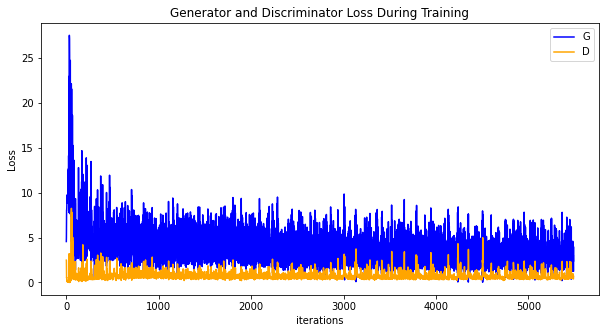

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

可视化训练过程中通过隐向量`fixed_noise`生成的图像。

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
    ani.save('./images/dcgan.gif', writer='pillow', fps=1)

showGif(image_list)

![dcgan](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/application/source_zh_cn/cv/images/dcgan.gif)

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。当训练周期数`num_epochs`达到50以上时，生成的动漫头像图片与数据集中的较为相似，如下：

![dcgan50](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/application/source_zh_cn/cv/images/dcgan50.png)